# MLP - Deniz özdemirli

## Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
np.random.seed(1)

## Activation functions

In [ ]:
def relu(Z):
  # Z as cache
  A = np.maximum(0, Z)
  return A, Z


def relu_backward(dA, cache):
  Z = cache
  dZ = np.array(dA, copy=True)
  dZ[Z <= 0] = 0
  return dZ


def sigmoid(Z):
  # Z as cache
  A = 1. / (1 + np.exp(-Z))
  return A, Z


def sigmoid_backward(dA, cache):
  Z = cache
  s = 1 / (1 + np.exp(-Z))
  dZ = dA * s * (1 - s)
  return dZ


def softmax(Z):
  # Z as cache
  Z = Z - np.max(Z, axis=0, keepdims=True)
  exponents = np.exp(Z)
  A = exponents / np.sum(exponents, axis=0, keepdims=True)
  return A, Z


def softmax_backward(dA, cache):
  Z = cache
  s, cache = softmax(Z)
  dZ = dA * s * (1 - s)
  return dZ

## Cost and Accuracy functions

In [ ]:
def cee(y_predict, y):
  classes, m = y.shape
  loss = -1 * (y * np.log(y_predict) + (1 - y) * np.log(1 - y_predict))
  cost = (1 / m) * np.sum(loss)
  return loss, cost


def classify(y):
  # y shape : (classes, m)
  classes, m = y.shape

  # Binary classification
  if classes == 1:
    return np.greater_equal(y, 0.5, casting='same_kind')

  # Multiclass classification
  else:
    return np.argmax(y, axis=0)


def compute_accuracy(y_predict, y_real):
  # y shape : (classes, m)
  classes, m = y_real.shape

  if classes == 1:
    accuracy = 100 - np.mean(np.abs(y_predict - y_real)) * 100

  else:
    y_predict_classified = classify(y_predict)
    y_real_classified = classify(y_real)
    num_equals = np.sum(y_predict_classified == y_real_classified)
    accuracy = num_equals / m

  return accuracy

## MLP

### Initialize parameters

In [ ]:
# Initialize w and b to small random values for every layer
def init_params(layers_dims):
  parameters = {}
  for l in range(1, len(layers_dims)):
    parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1]) * 0.01
    parameters['b' + str(l)] = np.random.randn(layers_dims[l], 1) * 0.01
  return parameters

### Forward propagation

In [ ]:
# W: Weights of layer L
# B: Bias term of layer L
# A: Activated values from layer L-1
# activation: Activation function of layer L

# Linear forward to calculate Z = WA + B
def linear_forward(A, W, b):
  Z = np.dot(W, A) + b
  cache = (A, W, b)
  return Z, cache


# Activation forward after linear forward
def linear_activation_forward(A, W, b, activation):
  Z, linear_cache = linear_forward(A, W, b)
  activation_cache = None
  if activation == 'relu':
    A, activation_cache = relu(Z)
  elif activation == 'sigmoid':
    A, activation_cache = sigmoid(Z)
  elif activation == 'softmax':
    A, activation_cache = softmax(Z)
  cache = (linear_cache, activation_cache)
  return A, cache


# Forward propagation from layer 1 to L
def forward_propagate(X, parameters):
  caches = []
  L = len(parameters) // 2
  A = X
  # Layers 0->L-1 Relu forward propagation
  for l in range(1, L):
    W = parameters['W' + str(l)]
    b = parameters['b' + str(l)]
    A, cache = linear_activation_forward(A, W, b, 'relu')
    caches.append(cache)

  # Layer L Sigmoid or Softmax forward propagation
  W = parameters['W' + str(L)]
  b = parameters['b' + str(L)]

  # Binary classification
  if W.shape[0] == 1:
    A, cache = linear_activation_forward(A, W, b, 'sigmoid')

  # Multiclass classification
  else:
    A, cache = linear_activation_forward(A, W, b, 'softmax')

  caches.append(cache)
  return A, caches

### Backward propagation

In [ ]:
# dA: derivative of loss with respect of activation
# dZ: derivative of loss with respect of Z
# dW: derivative of loss with respect of W
# dB: derivative of loss with respect of B

# Computes dW and db
def linear_backward(dZ, cache):
  A_prev, W, b = cache
  m = A_prev.shape[1]
  dW = np.dot(dZ, cache[0].T) / m
  db = np.sum(dZ, axis=1, keepdims=True) / m
  dA_prev = np.dot(cache[1].T, dZ)
  return dA_prev, dW, db


# Computes dZ
def linear_activation_backward(dA, cache, activation):
  linear_cache, activation_cache = cache
  dZ = None
  if activation == 'relu':
    dZ = relu_backward(dA, activation_cache)
  elif activation == 'sigmoid':
    dZ = sigmoid_backward(dA, activation_cache)
  elif activation == 'softmax':
    dZ = softmax_backward(dA, activation_cache)

  dA_prev, dW, db = linear_backward(dZ, linear_cache)
  return dA_prev, dW, db


# Backward propagation from layer L to 1
def backward_propagate(A_last, Y, caches):
  grads = {}
  L = len(caches)

  # Backpropagation for last layer L : sigmoid or softmax
  # CEE derivative
  current_cache = caches[-1]
  dA_last = - (np.divide(Y, A_last) - np.divide(1 - Y, 1 - A_last))

  # Binary classification
  if Y.shape[0] == 1:
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(
      dA_last,
      current_cache,
      activation="sigmoid"
    )

  # Multiclass classification
  else:
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(
      dA_last,
      current_cache,
      activation="softmax"
    )

  grads["dA" + str(L)] = dA_prev_temp
  grads["dW" + str(L)] = dW_temp
  grads["db" + str(L)] = db_temp

  # Backpropagation for layer L-1 to 1 : relu
  for l in reversed(range(L-1)):
    current_cache = caches[l]
    dA = grads["dA" + str(l + 2)]
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(
        dA,
        current_cache,
        activation="relu"
    )
    grads["dA" + str(l + 1)] = dA_prev_temp
    grads["dW" + str(l + 1)] = dW_temp
    grads["db" + str(l + 1)] = db_temp

  return grads

### Update parameters

In [ ]:
def update_parameters(parameters, gradients, learning_rate):
  L = len(parameters) // 2

  for l in range(L):
    W = parameters['W' + str(l+1)]
    dW = gradients['dW' + str(l+1)]
    parameters['W' + str(l+1)] = W - learning_rate * dW

    b = parameters['b' + str(l+1)]
    db = gradients['db' + str(l+1)]
    parameters['b' + str(l+1)] = b - learning_rate * db

  return parameters

### Model 

In [ ]:
def model(X, Y, layers_dims, iterations, learning_rate, iter_log):
  # Init parameters
  parameters = init_params(layers_dims)
  costs = []
  accuracies = []

  for i in range(iterations):
    # Forward propagation
    A_last, caches = forward_propagate(X, parameters)

    # Cost and Accuracy
    loss, cost = cee(A_last, Y)
    costs.append(cost)
    accuracy = compute_accuracy(A_last, Y)
    accuracies.append(accuracy)

    # Backward propagation
    gradients = backward_propagate(A_last, Y, caches)

    # Update parameters
    parameters = update_parameters(parameters, gradients, learning_rate)

    # Print cost and accuracy
    if (not iter_log == 0) and (i % iter_log == 0 or i == iterations - 1):
      print('Iteration:', i, '  cost:', cost, ' accuracy:', accuracy)

  report = {
    'costs': costs,
    'accuracies': accuracies
  }

  return parameters, report

## MNIST dataset

### Visualize the data

In [ ]:
from keras.datasets import mnist
from keras.utils import np_utils
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
print("The MNIST database has a training set of %d examples." % len(x_train))
print("The MNIST database has a test set of %d examples." % len(x_test))

The MNIST database has a training set of 60000 examples.
The MNIST database has a test set of 10000 examples.


In [ ]:
x_train

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [ ]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

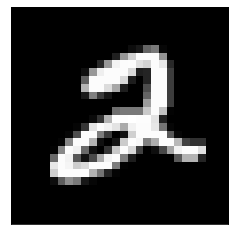

In [ ]:
# pick a sample to plot
sample = 5
image = x_train[sample]
# plot the sample
fig = plt.figure
plt.xticks([])
plt.yticks([])
plt.imshow(image, cmap='gray')
plt.show()

In [ ]:
for row in x_train[sample]:
    for i in row:
        print("%3s "%i, end='')
    print()

  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  13  25 100 122   7   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0  33 151 208 252 252 252 146   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0  40 152 244 252 253 224 211 252 232  40   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0  15 152 239 252 252 252 216  31  37 252 252  60   0   0   0 

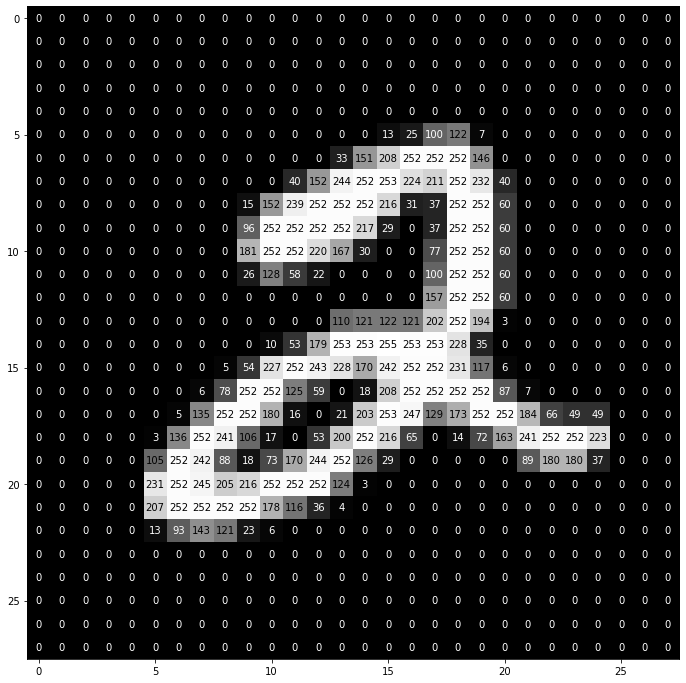

In [ ]:
#View an Image in More Detail
def visualize_input(img, ax):
    ax.imshow(img, cmap='gray')
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            ax.annotate(str(round(img[x][y],2)), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img[x][y]<thresh else 'black')

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
visualize_input(x_train[sample], ax)

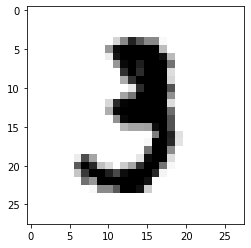

In [ ]:
# pick a sample to plot
sample = 10
image = x_train[sample]
# plot the sample
fig = plt.figure
plt.imshow(image, cmap='gray_r')
plt.show()

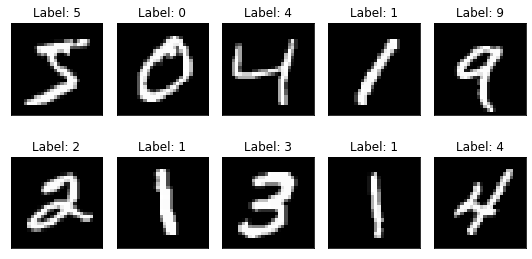

In [ ]:
# plot 10 images with labels
num = 10
images = x_train[:num]
labels = y_train[:num]

num_row = 2
num_col = 5
# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i], cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

In [ ]:
print("train data")
y_value=np.zeros((1,10))
for i in range (10):
    print("occurance of ",i,"=",np.count_nonzero(y_train==i))
    y_value[0,i-1]= np.count_nonzero(y_train==i)

train data
occurance of  0 = 5923
occurance of  1 = 6742
occurance of  2 = 5958
occurance of  3 = 6131
occurance of  4 = 5842
occurance of  5 = 5421
occurance of  6 = 5918
occurance of  7 = 6265
occurance of  8 = 5851
occurance of  9 = 5949


<BarContainer object of 10 artists>

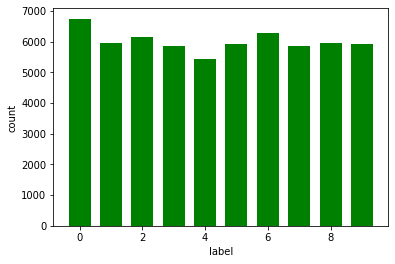

In [ ]:
y_value=y_value.ravel()
x_value=[0,1,2,3,4,5,6,7,8,9]
plt.xlabel('label')
plt.ylabel('count')
plt.bar(x_value,y_value,0.7,color='g')

### Preprocess the data

We need to reshape the MNIST data depending on the type of input layer of neural network models. For an MLP (Multilayer Perceptron), an image in the MNIST dataset should be reshaped as follows.

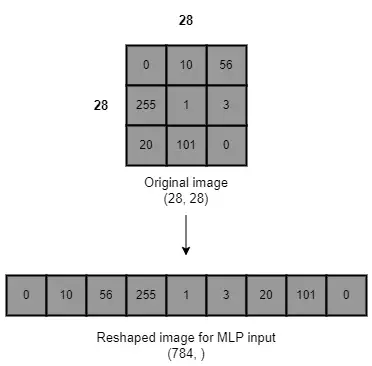

In [ ]:
# Global constants
N_CLASS = 10
N_TRAIN, HEIGHT, WIDTH = x_train.shape
N_TEST = x_test.shape[0]

# Data preprocessing
x_train_flatten = x_train.reshape(N_TRAIN, -1).T
y_train_flatten = y_train.reshape(N_TRAIN, -1)
x_test_flatten = x_test.reshape(N_TEST, -1).T
y_test_flatten = y_test.reshape(N_TEST, -1)

# Normalize data
X_train = x_train_flatten.astype('float32') / 255
X_test = x_test_flatten.astype('float32') / 255

# Categorize output into 10 classes
Y_train = np_utils.to_categorical(y_train_flatten, N_CLASS).T
Y_test = np_utils.to_categorical(y_test_flatten, N_CLASS).T

In [ ]:
print("Shapes before preprocessing :")
print("Training images: ", x_train.shape) 
print("Training labels: ",y_train.shape)
print("Test images: ",x_test.shape)
print("Test Labels: ",y_test.shape)

Shapes before preprocessing :
Training images:  (60000, 28, 28)
Training labels:  (60000,)
Test images:  (10000, 28, 28)
Test Labels:  (10000,)


In [ ]:
print("Shapes after preprocessing :")
print("Training images: ", X_train.shape) 
print("Training labels: ",Y_train.shape)
print("Test images: ",X_test.shape)
print("Test Labels: ",Y_test.shape)

Shapes after preprocessing :
Training images:  (784, 60000)
Training labels:  (10, 60000)
Test images:  (784, 10000)
Test Labels:  (10, 10000)


In [ ]:
Y_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
pd.DataFrame(Y_train)

,0,1,2,3,4,5,6,7,8,9,...,59990,59991,59992,59993,59994,59995,59996,59997,59998,59999
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
9,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
pd.DataFrame(Y_train).iloc[:, 0] # Label 5

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
5    1.0
6    0.0
7    0.0
8    0.0
9    0.0
Name: 0, dtype: float32

## Network 1 : 

*   Layer Configurations : [784,128,10] 
*   Activations : [relu, softmax] 
*   Epoche : 400
*   Learning Rate : 0.2





### Train the Model

In [ ]:
# relu softmax
N_FEATURE = WIDTH * HEIGHT
N_HIDDEN = 128
N_CLASS = 10
LAYERS = [N_FEATURE, N_HIDDEN, N_CLASS]
N_EPOCH = 400
LEARNING_RATE = 0.2
REPORT_MOD = 100

parameters, report = model(X_train, Y_train, LAYERS, N_EPOCH, LEARNING_RATE, REPORT_MOD)

Iteration: 0   cost: 3.2504170375796555  accuracy: 0.10295
Iteration: 100   cost: 0.8579980456423326  accuracy: 0.8683666666666666
Iteration: 200   cost: 0.611722805408027  accuracy: 0.89935
Iteration: 300   cost: 0.5383887869070562  accuracy: 0.9099333333333334
Iteration: 399   cost: 0.4960954036322829  accuracy: 0.9166333333333333


### Test the Model

In [ ]:
parameters_test, report_test = model(X_test, Y_test, LAYERS, N_EPOCH, LEARNING_RATE, REPORT_MOD)

Iteration: 0   cost: 3.250513901967682  accuracy: 0.1218
Iteration: 100   cost: 0.7933290060772188  accuracy: 0.8791
Iteration: 200   cost: 0.5445344805550671  accuracy: 0.9098
Iteration: 300   cost: 0.462911558061818  accuracy: 0.9251
Iteration: 399   cost: 0.4126200458223904  accuracy: 0.9325


### Results

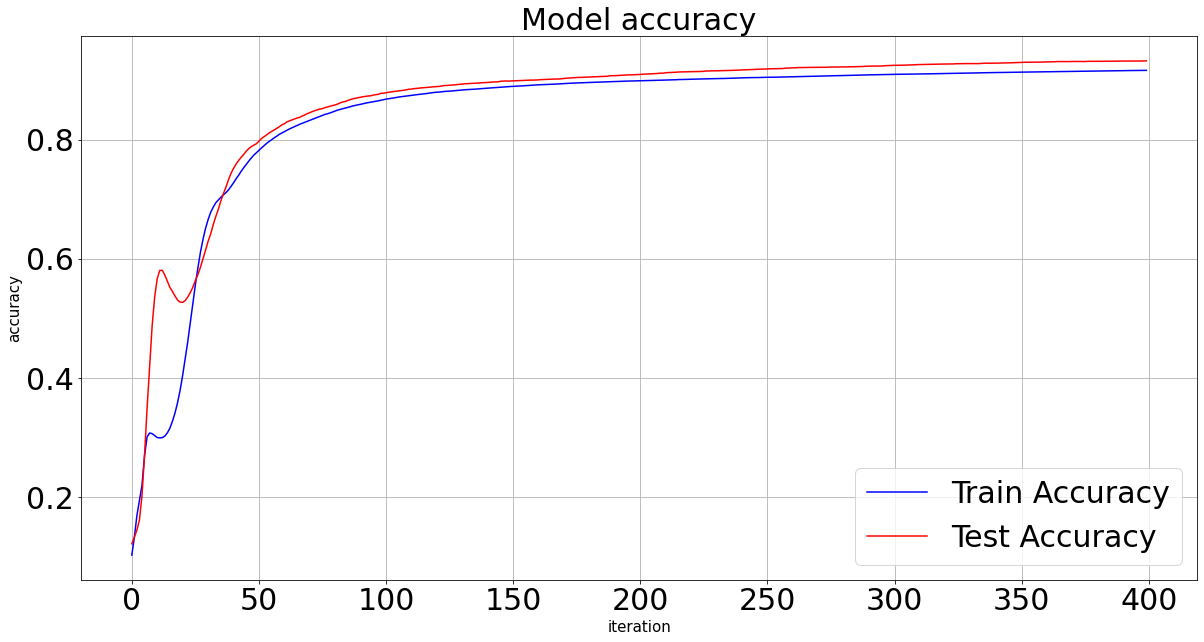

In [ ]:
# Accuracy plot
plt.figure(figsize=(20,10))
plt.plot(report['accuracies'],'b', label="Train Accuracy")
plt.plot(report_test['accuracies'],'r', label="Test Accuracy")
plt.title('Model accuracy',fontsize=30)
plt.ylabel('accuracy',fontsize=15)
plt.xlabel('iteration',fontsize=15)
plt.legend(prop={'size': 30},loc='lower right')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.grid()
plt.show()

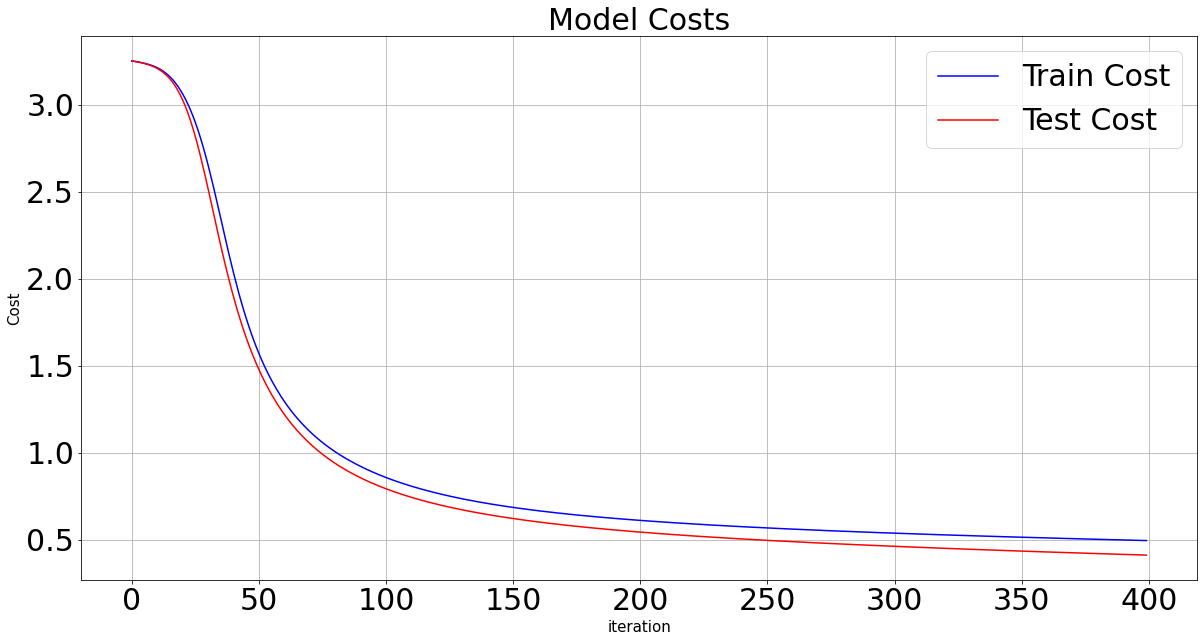

In [ ]:
# Cost plot
plt.figure(figsize=(20,10))
plt.plot(report['costs'],'b', label="Train Cost")
plt.plot(report_test['costs'],'r', label="Test Cost")
plt.title('Model Costs',fontsize=30)
plt.ylabel('Cost', fontsize=15)
plt.xlabel('iteration', fontsize=15)
plt.legend(prop={'size': 30})
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.grid()
plt.show()

### Evaluation

In [ ]:
y_predict, cache = forward_propagate(X_test, parameters)
test_accuracy = compute_accuracy(y_predict, Y_test)
loss, test_cost = cee(y_predict, Y_test)
print('Accuracy on test dataset:', test_accuracy)
print('Cost on test dataset:', test_cost)

Accuracy on test dataset: 0.919
Cost on test dataset: 0.4802835713142539


## Network 2 : 

*   Layer Configurations : [784,128,10] 
*   Activations : [sigmoid, softmax] 
*   Epoche : 1000
*   Learning Rate : 0.03





### Train the Model

In [ ]:
# sigmoid softmax
N_FEATURE = WIDTH * HEIGHT
N_HIDDEN = 128
N_CLASS = 10
LAYERS = [N_FEATURE, N_HIDDEN, N_CLASS]
N_EPOCH = 200
LEARNING_RATE = 0.03
REPORT_MOD = 100

parameters2, report2 = model(X_train, Y_train, LAYERS, N_EPOCH, LEARNING_RATE, REPORT_MOD)

Iteration: 0   cost: 3.250524087041244  accuracy: 0.11148333333333334
Iteration: 100   cost: 3.2226733416355366  accuracy: 0.42013333333333336
Iteration: 199   cost: 3.1582142955244334  accuracy: 0.4738


### Test the Model

In [ ]:
parameters_test2, report_test2 = model(X_test, Y_test, LAYERS, N_EPOCH, LEARNING_RATE, REPORT_MOD)

Iteration: 0   cost: 3.2498011893611634  accuracy: 0.1032
Iteration: 100   cost: 3.223990035978493  accuracy: 0.298
Iteration: 199   cost: 3.1610043782471418  accuracy: 0.499


### Results

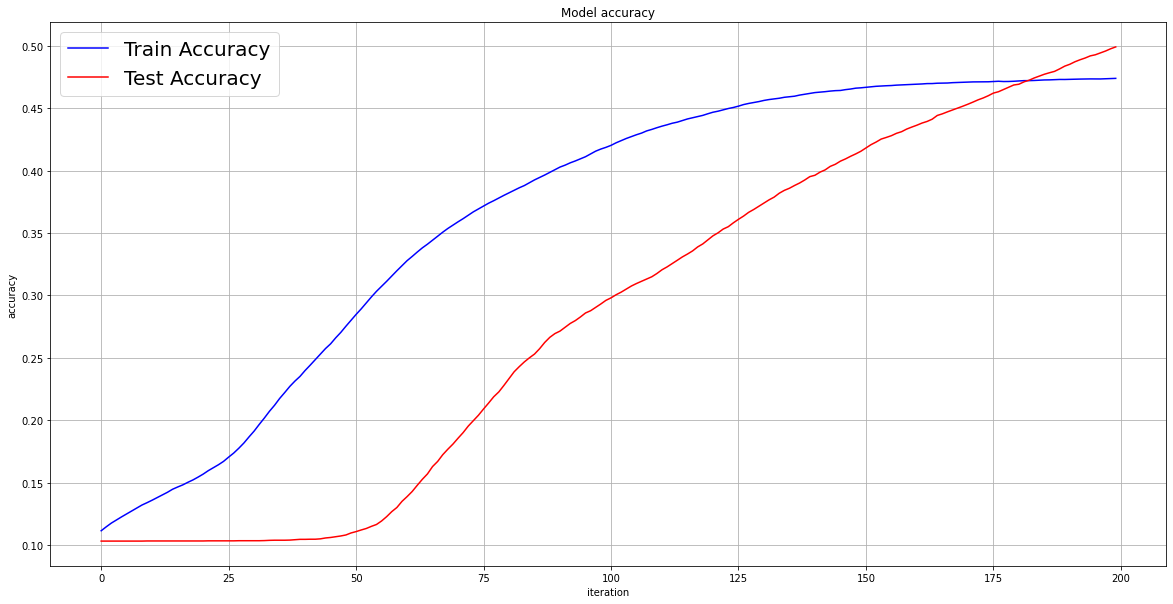

In [ ]:
# Accuracy plot
plt.figure(figsize=(20,10))
plt.plot(report2['accuracies'],'b', label="Train Accuracy")
plt.plot(report_test2['accuracies'],'r', label="Test Accuracy")
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('iteration')
plt.legend(prop={'size': 20})
plt.grid()
plt.show()

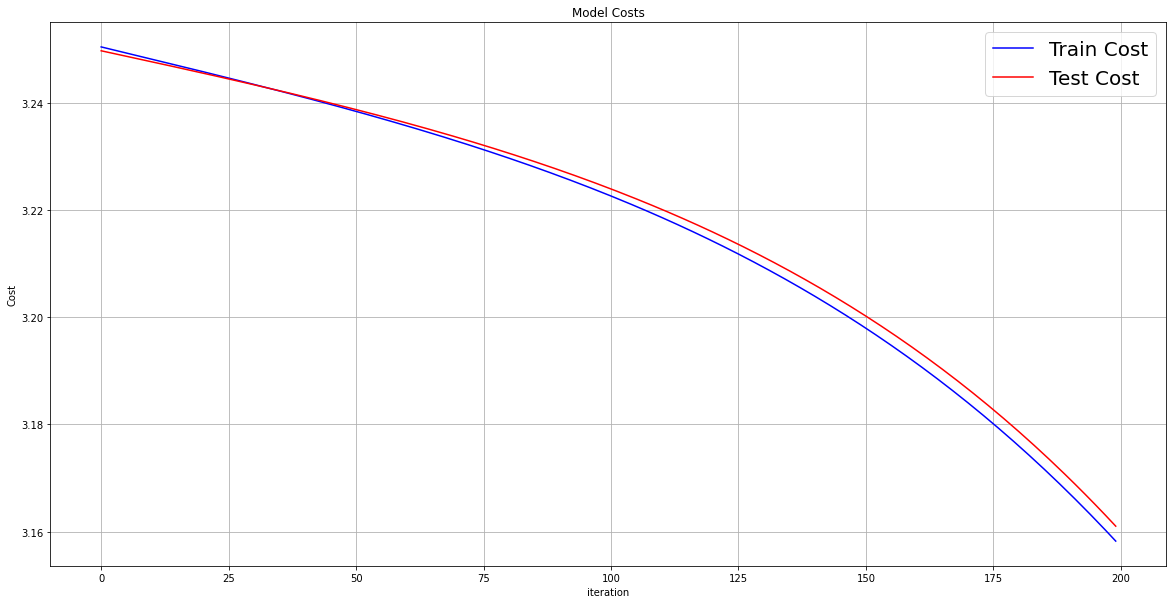

In [ ]:
# Cost plot
plt.figure(figsize=(20,10))
plt.plot(report2['costs'],'b', label="Train Cost")
plt.plot(report_test2['costs'],'r', label="Test Cost")
plt.title('Model Costs')
plt.ylabel('Cost')
plt.xlabel('iteration')
plt.legend(prop={'size': 20})
plt.grid()
plt.show()

### Evaluation

In [ ]:
y_predict2, cache = forward_propagate(X_test, parameters2)
test_accuracy2 = compute_accuracy(y_predict2, Y_test)
loss2, test_cost2 = cee(y_predict2, Y_test)
print('Accuracy on test dataset:', test_accuracy2)
print('Cost on test dataset:', test_cost2)

Accuracy on test dataset: 0.4768
Cost on test dataset: 3.1552394059094326


## Network 3 : 

*   Layer Configurations : [784,512,128,10] 
*   Activations : [relu,relu, softmax] 
*   Epoche : 2000
*   Learning Rate : 0.2





### Train the Model

In [ ]:
# relu relu softmax
N_FEATURE = WIDTH * HEIGHT
N_HIDDEN1 = 512
N_HIDDEN2 = 128
N_CLASS = 10
LAYERS = [N_FEATURE, N_HIDDEN1, N_HIDDEN2, N_CLASS]
N_EPOCH = 400
LEARNING_RATE = 0.2
REPORT_MOD = 100

parameters3, report3 = model(X_train, Y_train, LAYERS, N_EPOCH, LEARNING_RATE, REPORT_MOD)

Iteration: 0   cost: 3.2508067522608597  accuracy: 0.10871666666666667
Iteration: 100   cost: 2.8703259279892106  accuracy: 0.39566666666666667
Iteration: 200   cost: 1.0964693988724332  accuracy: 0.7855666666666666
Iteration: 300   cost: 0.6478644140773309  accuracy: 0.8900666666666667
Iteration: 399   cost: 0.5306340370493592  accuracy: 0.9107333333333333


### Test the Model

In [ ]:
parameters_test3, report_test3 = model(X_test, Y_test, LAYERS, N_EPOCH, LEARNING_RATE, REPORT_MOD)

Iteration: 0   cost: 3.2510501412048978  accuracy: 0.101
Iteration: 100   cost: 2.758357856626602  accuracy: 0.4629
Iteration: 200   cost: 1.0937808002090197  accuracy: 0.7895
Iteration: 300   cost: 0.6025071314737156  accuracy: 0.8928
Iteration: 399   cost: 0.46599029062925323  accuracy: 0.9215


### Results

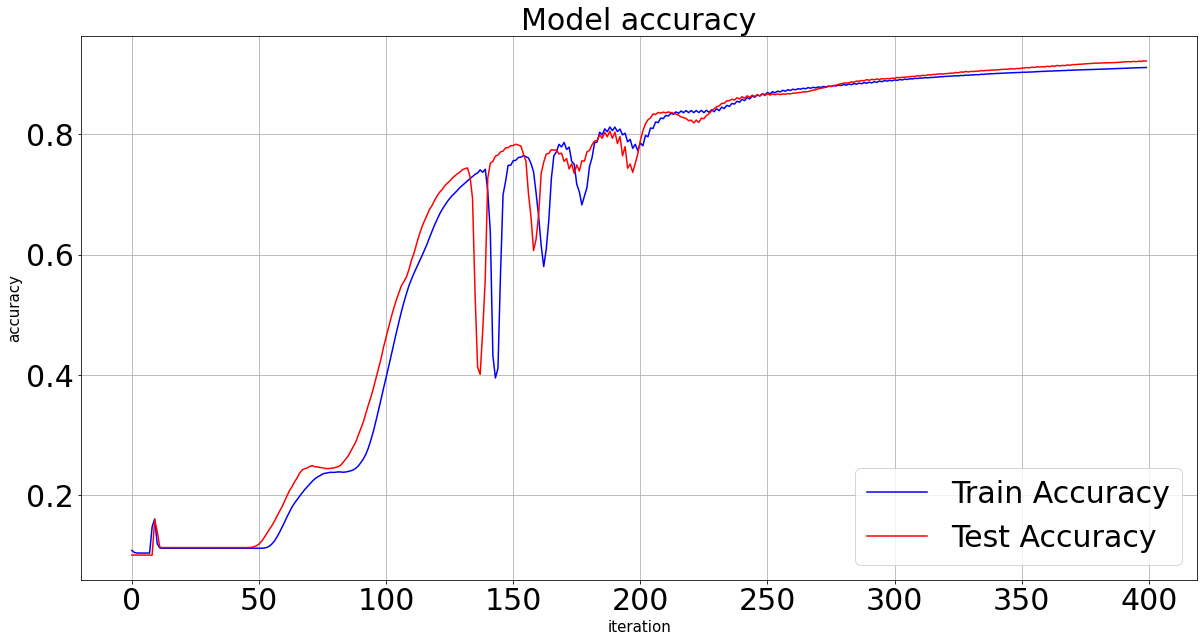

In [ ]:
# Accuracy plot
plt.figure(figsize=(20,10))
plt.plot(report3['accuracies'],'b', label="Train Accuracy")
plt.plot(report_test3['accuracies'],'r', label="Test Accuracy")
plt.title('Model accuracy',fontsize=30)
plt.ylabel('accuracy',fontsize=15)
plt.xlabel('iteration',fontsize=15)
plt.legend(prop={'size': 30},loc='lower right')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.grid()
plt.show()

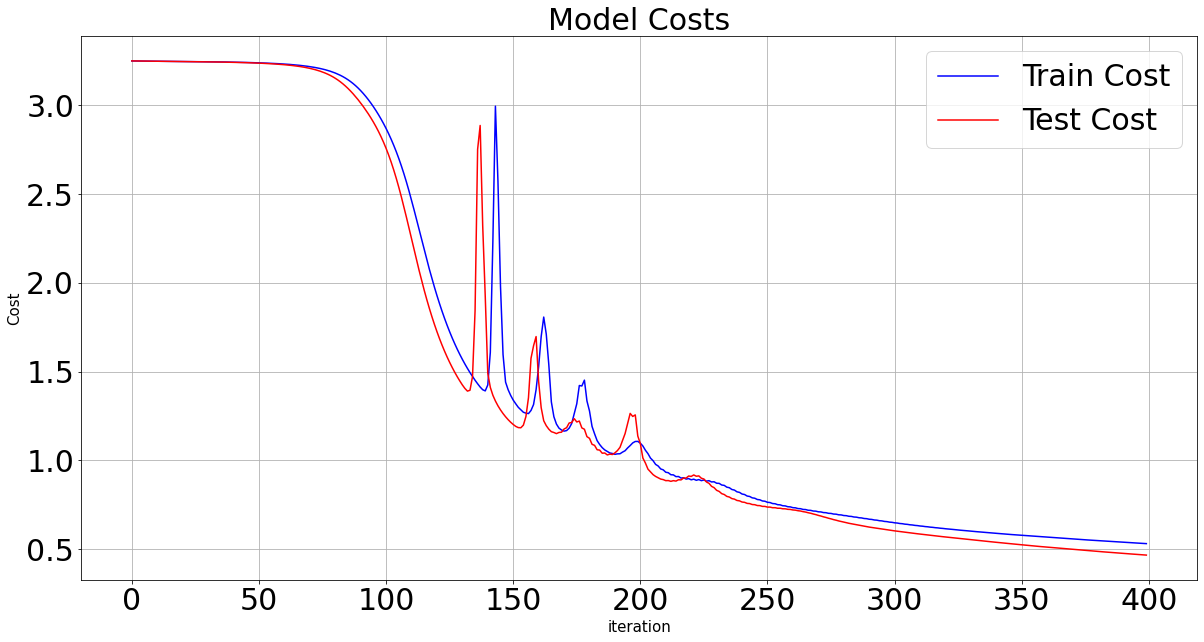

In [ ]:
# Cost plot
plt.figure(figsize=(20,10))
plt.plot(report3['costs'],'b', label="Train Cost")
plt.plot(report_test3['costs'],'r', label="Test Cost")
plt.title('Model Costs',fontsize=30)
plt.ylabel('Cost', fontsize=15)
plt.xlabel('iteration', fontsize=15)
plt.legend(prop={'size': 30})
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.grid()
plt.show()

### Evaluation

In [ ]:
y_predict3, cache = forward_propagate(X_test, parameters3)
test_accuracy3 = compute_accuracy(y_predict3, Y_test)
loss3, test_cost3 = cee(y_predict3, Y_test)
print('Accuracy on test dataset:', test_accuracy3)
print('Cost on test dataset:', test_cost3)

Accuracy on test dataset: 0.9109
Cost on test dataset: 0.5152750421997029


## Network 4 : 

*   Layer Configurations : [784,128,10] 
*   Activations : [sigmoid, softmax] 
*   Epoche : 2000
*   Learning Rate : 0.2





### Train the Model

In [ ]:
# sigmoid softmax
N_FEATURE = WIDTH * HEIGHT
N_HIDDEN = 128
N_CLASS = 10
LAYERS = [N_FEATURE, N_HIDDEN, N_CLASS]
N_EPOCH = 400
LEARNING_RATE = 0.2
REPORT_MOD = 100

parameters4, report4 = model(X_train, Y_train, LAYERS, N_EPOCH, LEARNING_RATE, REPORT_MOD)

KeyboardInterrupt: ignored

### Test the Model

In [ ]:
parameters_test4, report_test4 = model(X_test, Y_test, LAYERS, N_EPOCH, LEARNING_RATE, REPORT_MOD)

Iteration: 0   cost: 3.2504025703750155  accuracy: 0.1031


KeyboardInterrupt: ignored

### Results

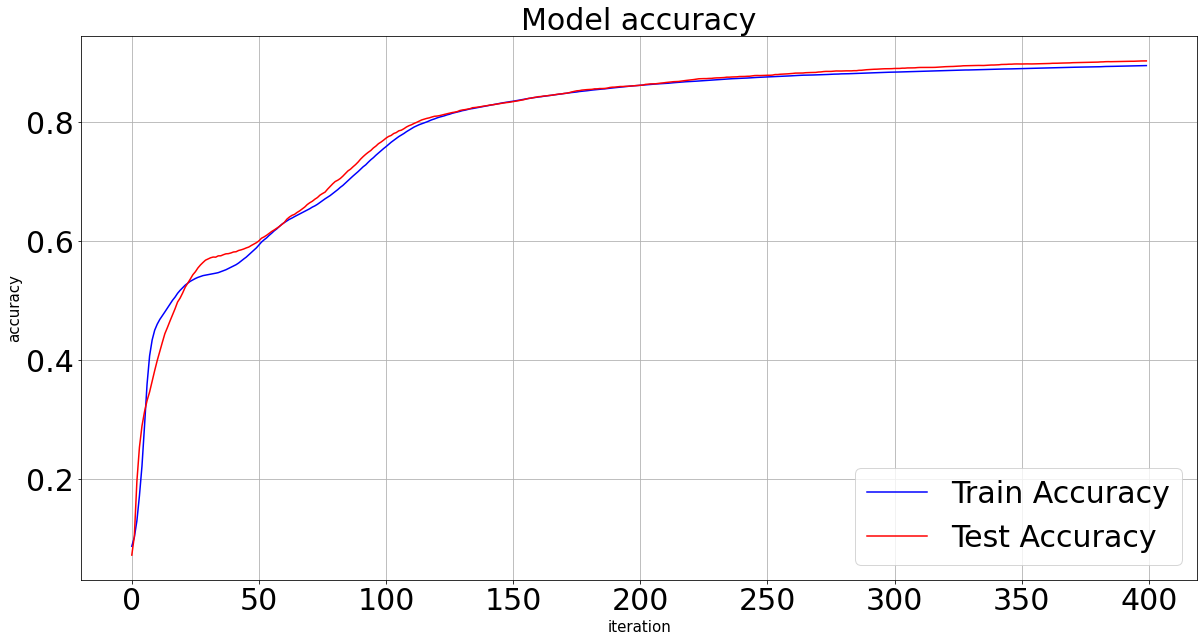

In [ ]:
# Accuracy plot
plt.figure(figsize=(20,10))
plt.plot(report4['accuracies'],'b', label="Train Accuracy")
plt.plot(report_test4['accuracies'],'r', label="Test Accuracy")
plt.title('Model accuracy',fontsize=30)
plt.ylabel('accuracy',fontsize=15)
plt.xlabel('iteration',fontsize=15)
plt.legend(prop={'size': 30},loc='lower right')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.grid()
plt.show()

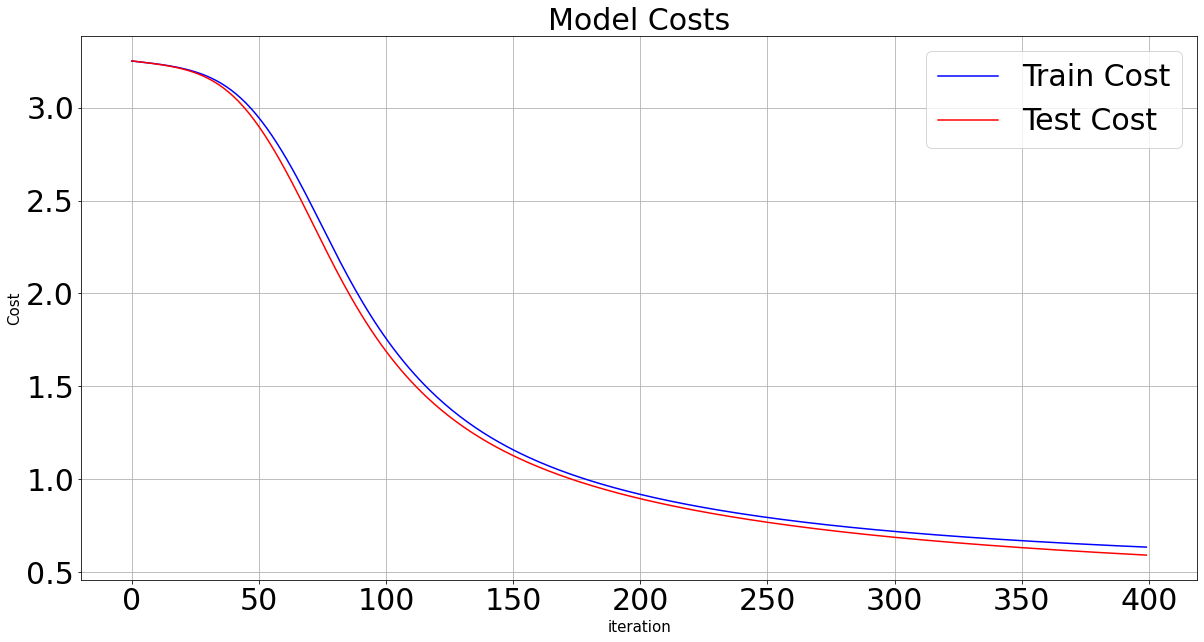

In [ ]:
# Cost plot
plt.figure(figsize=(20,10))
plt.plot(report4['costs'],'b', label="Train Cost")
plt.plot(report_test4['costs'],'r', label="Test Cost")
plt.title('Model Costs',fontsize=30)
plt.ylabel('Cost', fontsize=15)
plt.xlabel('iteration', fontsize=15)
plt.legend(prop={'size': 30})
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.grid()
plt.show()

### Evaluation

In [ ]:
y_predict4, cache = forward_propagate(X_test, parameters4)
test_accuracy4 = compute_accuracy(y_predict4, Y_test)
loss4, test_cost4 = cee(y_predict4, Y_test)
print('Accuracy on test dataset:', test_accuracy4)
print('Cost on test dataset:', test_cost4)

Accuracy on test dataset: 0.9015
Cost on test dataset: 0.6042669183446288


## Network 5 : 

*   Layer Configurations : [784,128,10] 
*   Activations : [relu, softmax] 
*   Epoche : 2000
*   Learning Rate : 0.03





### Train the Model

In [ ]:
# relu softmax
N_FEATURE = WIDTH * HEIGHT
N_HIDDEN = 128
N_CLASS = 10
LAYERS = [N_FEATURE, N_HIDDEN, N_CLASS]
N_EPOCH = 400
LEARNING_RATE = 0.03
REPORT_MOD = 100

parameters5, report5 = model(X_train, Y_train, LAYERS, N_EPOCH, LEARNING_RATE, REPORT_MOD)

Iteration: 0   cost: 3.250963722027825  accuracy: 0.09868333333333333
Iteration: 100   cost: 3.147981529565369  accuracy: 0.40116666666666667
Iteration: 200   cost: 2.559359076179038  accuracy: 0.6929
Iteration: 300   cost: 1.7101873922043003  accuracy: 0.7718166666666667
Iteration: 399   cost: 1.2729317749248448  accuracy: 0.8176


### Test the Model

In [ ]:
parameters_test5, report_test5 = model(X_test, Y_test, LAYERS, N_EPOCH, LEARNING_RATE, REPORT_MOD)

Iteration: 0   cost: 3.251590396681595  accuracy: 0.0949
Iteration: 100   cost: 3.1554090360043086  accuracy: 0.5148
Iteration: 200   cost: 2.535918996002998  accuracy: 0.6874
Iteration: 300   cost: 1.666601991266771  accuracy: 0.7893
Iteration: 399   cost: 1.2182312515080345  accuracy: 0.8272


### Results

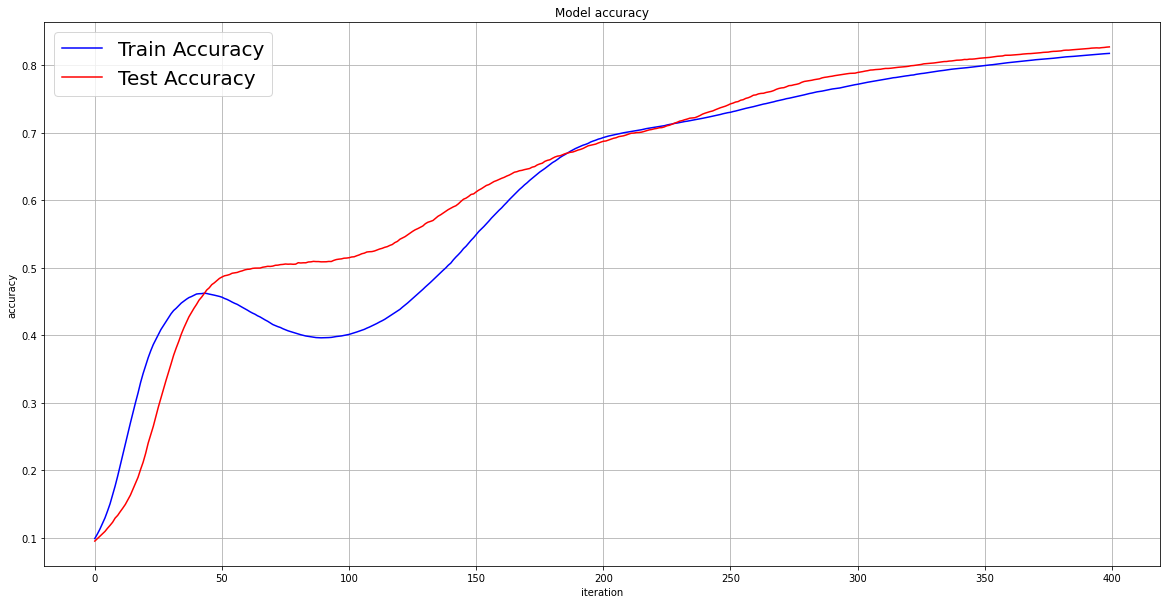

In [ ]:
# Accuracy plot
plt.figure(figsize=(20,10))
plt.plot(report5['accuracies'],'b', label="Train Accuracy")
plt.plot(report_test5['accuracies'],'r', label="Test Accuracy")
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('iteration')
plt.legend(prop={'size': 20})
plt.grid()
plt.show()

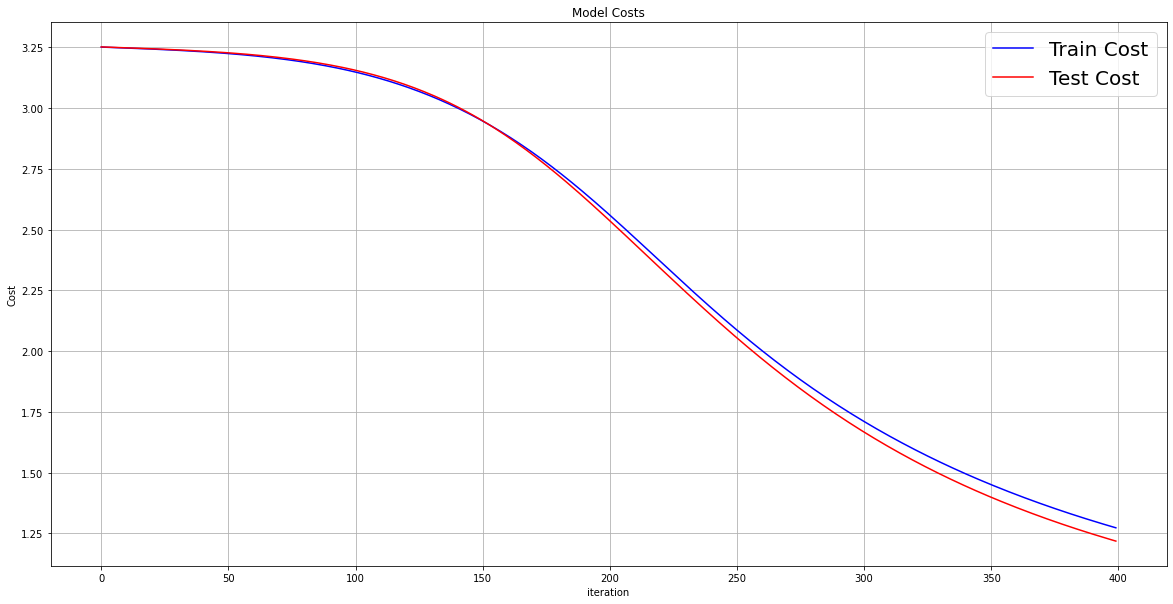

In [ ]:
# Cost plot
plt.figure(figsize=(20,10))
plt.plot(report5['costs'],'b', label="Train Cost")
plt.plot(report_test5['costs'],'r', label="Test Cost")
plt.title('Model Costs')
plt.ylabel('Cost')
plt.xlabel('iteration')
plt.legend(prop={'size': 20})
plt.grid()
plt.show()

### Evaluation

In [ ]:
y_predict5, cache = forward_propagate(X_test, parameters5)
test_accuracy5 = compute_accuracy(y_predict5, Y_test)
loss4, test_cost5 = cee(y_predict5, Y_test)
print('Accuracy on test dataset:', test_accuracy5)
print('Cost on test dataset:', test_cost5)

Accuracy on test dataset: 0.8235
Cost on test dataset: 1.2433236710937519
